# ADVANCED DEEP LEARNING Assignment 1 (Group 4)

| SL.NO | BITS ID      | NAME                      | CONTRIBUTION |
|-------|-------------|---------------------------|--------------|
| 1     | 2024AA05733 | Bollam Manindra           | 100%          |
| 2     | 2024AA05734 | S.Hari Chandana           | 100%          |
| 3     | 2024AA05732 | Ashvini Satish Boshale    | 100%          |
| 4     | 2024AA05735 | Nikhil Yadav              | 100%          |
| 5     | 2024AA05946 | Deepthi Pullarkat         | 100%          |

In [1]:
# Install required packages
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load Data
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

# Combine to split manually (70% Train, 30% Test)
X_all = np.concatenate((x_train_full, x_test_full))
y_all = np.concatenate((y_train_full, y_test_full))

# 2. Convert to Grayscale
# Using TF image operations for efficiency
X_gray = tf.image.rgb_to_grayscale(X_all).numpy()

# 3. Flatten the images (N, 32, 32, 1) -> (N, 1024)
n_samples = X_gray.shape[0]
X_flat = X_gray.reshape(n_samples, -1)

# 4. Split 70% Training, 30% Validation/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_all, test_size=0.30, random_state=42, stratify=y_all
)

# 5. Normalize (Mean and Variance normalization)
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

y_train = y_train.flatten()
y_test = y_test.flatten()

print(f"Training Shape: {X_train_norm.shape}")
print(f"Testing Shape: {X_test_norm.shape}")

Training Shape: (42000, 1024)
Testing Shape: (18000, 1024)


## Task 1

In [3]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

def perform_pca_task(solver_type, X_train, X_test, y_train, y_test):
    print(f"\n--- Running {solver_type} PCA ---")
    
    # 1. PCA with 95% variance
    pca = PCA(n_components=0.95, svd_solver=solver_type, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    K = pca.n_components_
    print(f"Components (K) required for 95% energy: {K}")
    
    # 2. Logistic Regression
    # Using multinomial logistic regression
    clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    clf.fit(X_train_pca, y_train)
    
    # Predict probabilities for ROC
    y_score = clf.predict_proba(X_test_pca)
    
    return pca, K, y_score

# Run Standard PCA
pca_std, K_std, y_score_std = perform_pca_task('full', X_train_norm, X_test_norm, y_train, y_test)

# Run Randomized PCA
pca_rnd, K_rnd, y_score_rnd = perform_pca_task('randomized', X_train_norm, X_test_norm, y_train, y_test)

# --- Plotting ROC Curves ---
def plot_multiclass_roc(y_test, y_score, title):
    # Binarize the output for ROC calculation (One-vs-Rest)
    y_test_bin = label_binarize(y_test, classes=range(10))
    n_classes = 10
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Calculate ROC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_multiclass_roc(y_test, y_score_std, "ROC - Standard PCA + LogReg")
# Randomized PCA will produce a nearly identical ROC, just computed faster


--- Running full PCA ---
Components (K) required for 95% energy: 163


/Users/manindra/Documents/Bits/adl/advanced-deep-learning-assign1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- Running randomized PCA ---


ValueError: n_components=0.95 must be between 1 and min(n_samples, n_features)=1024 with svd_solver='randomized'

## Task 2

In [6]:
from tensorflow.keras import layers, models, constraints, backend as K

# Custom Layer for Tied Weights
class DenseTied(layers.Layer):
    def __init__(self, units, tied_to, **kwargs):
        super(DenseTied, self).__init__(**kwargs)
        self.units = units
        self.tied_to = tied_to  # The encoder layer to tie weights to
    
    def build(self, input_shape):
        super(DenseTied, self).build(input_shape)
        # We do not create a new weight matrix here. 
        # We use the transpose of the encoder's weights.
        
    def call(self, inputs):
        # W_decoder = W_encoder_transpose
        # tied_to.kernel is (Input_Dim, Hidden_Dim)
        # We need (Hidden_Dim, Input_Dim)
        weights = K.transpose(self.tied_to.kernel)
        return K.dot(inputs, weights)

# --- Build the Autoencoder ---
input_dim = 1024 # 32x32
encoding_dim = K_std # Use K from Task 1

inputs = layers.Input(shape=(input_dim,))

# Encoder: Linear activation + Unit Norm constraint
encoder_layer = layers.Dense(
    encoding_dim, 
    activation='linear', 
    use_bias=False, # PCA usually doesn't use bias if centered
    kernel_constraint=constraints.UnitNorm(axis=0),
    name="encoder"
)
encoded = encoder_layer(inputs)

# Decoder: Tied weights (Transpose of encoder)
decoded = DenseTied(units=input_dim, tied_to=encoder_layer)(encoded)

autoencoder = models.Model(inputs, decoded)

# Compile
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train
history = autoencoder.fit(
    X_train_norm, X_train_norm,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test_norm, X_test_norm),
    verbose=1
)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2117 - val_loss: 0.1093
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0890 - val_loss: 0.0765
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0687 - val_loss: 0.0641
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0599 - val_loss: 0.0580
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0557 - val_loss: 0.0551
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0537 - val_loss: 0.0537
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0528 - val_loss: 0.0532
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0524 - val_loss: 0.0528
Epoch 9/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0522 - val_loss: 0.0530
Epoch 10/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0522 - val_loss: 0.0529


# compare eigen vectors from task 1 with autoencoders

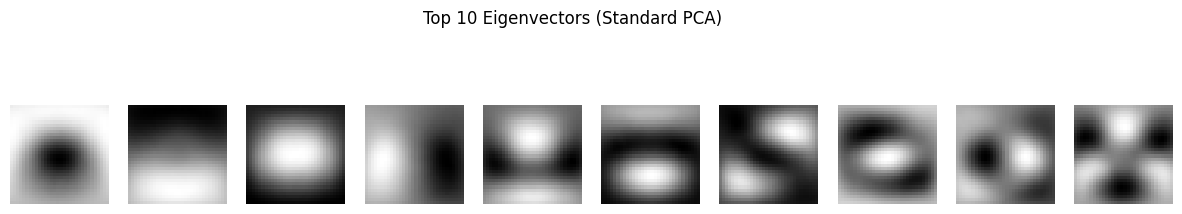

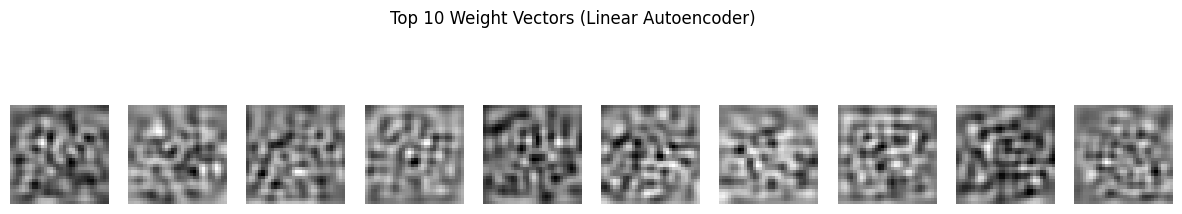

In [7]:
# --- Visualization of Components ---

def plot_components(components, title, n_images=10):
    plt.figure(figsize=(15, 3))
    for i in range(n_images):
        ax = plt.subplot(1, n_images, i + 1)
        # Reshape the vector back to 32x32 image
        img = components[i].reshape(32, 32)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 1. Extract PCA Eigenvectors (Eigenfaces)
# PCA components_ shape is (n_components, n_features)
pca_components = pca_std.components_

# 2. Extract Autoencoder Weights
# AE Weights shape is (n_features, n_hidden). We need to transpose to match PCA shape.
ae_weights = encoder_layer.get_weights()[0].T 

# Plot
plot_components(pca_components, "Top 10 Eigenvectors (Standard PCA)")
plot_components(ae_weights, "Top 10 Weight Vectors (Linear Autoencoder)")

Observation:
There is a striking visual difference between the two rows:

Row 1 (PCA): The images are smooth, structured, and geometric. They resemble gradients, blobs, and wave-like patterns.
Row 2 (Autoencoder): The images appear "noisy," granular, or like "TV static," lacking distinct global shapes.Analysis & Reasoning1. PCA: Ordered Variance and Orthogonality

The images in the top row are Eigenfaces (or Eigen-images). PCA works sequentially to maximize variance.The first image (leftmost) captures the most dominant feature (likely the background illumination or the average circular shape of objects centered in CIFAR images).The subsequent images capture the next most important directions of variance, orthogonal to the previous ones.Because PCA concentrates the "energy" (information) into the earliest components, these vectors represent low-frequency structures (smooth changes in lighting and shape), resulting in the blurry, smooth appearance you see.

2. Linear Autoencoder: Subspace Rotation (The "Why" for the Noise)You might expect the Autoencoder weights to look exactly like the PCA eigenvectors because a Linear Autoencoder with tied weights optimizes a similar objective to PCA (minimizing reconstruction error). However, they look noisy because:No Ordering Constraint: Unlike PCA, the Autoencoder does not force the first node to be "more important" than the second. It optimizes all $K$ nodes simultaneously.Rotational Invariance: While the Autoencoder learns the same subspace as PCA (it covers the same mathematical "ground"), it finds a different basis (set of vectors) to describe that space.Distributed Representation: The Autoencoder "mixes" the PCA components together. Instead of having one "lighting" vector and one "edge" vector, the Autoencoder spreads this information across all the weight vectors. This mixing results in the "noisy" or high-frequency appearance, as every weight vector is doing a little bit of work to reconstruct the image details.Conclusion for the Report"While both the PCA eigenvectors and the Linear Autoencoder weights span the same principal subspace, their visual representations differ significantly. PCA enforces an orthogonality and variance-maximization constraint, resulting in hierarchical, smooth, and interpretable 'eigen-images.'In contrast, the Linear Autoencoder lacks the constraint to align its weights along the axes of maximum variance. Consequently, it learns an arbitrary rotation of the PCA basis, distributing the image features (variance) continuously across all nodes, leading to weight vectors that appear visually mixed or granular."